# Logistic Regression vs Neural Network on a 2D Toy Classification Task

This notebook accompanies Example `\ref{ex:2d-single-fully}` and the related exercise
in Chapter 4 of the *Mathematics of Generative AI* living book.

We compare:

1. **Logistic Regression with nonlinear features** (explicit feature engineering).
2. **A single-hidden-layer fully connected neural network**, which *learns* a nonlinear feature map.

Our goal is to:
- Construct a synthetic 2D dataset with a nonlinearly separable decision boundary.
- Train both models on the same data.
- Visualize and save figures illustrating the ground-truth boundary, the learned boundaries, and training behavior.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim

# Make sure we have a directory for figures
os.makedirs("figs", exist_ok=True)

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)


## 1. Data Generation

We generate 2D points uniformly in a square domain and assign binary labels based on
their distance to two overlapping circles. This produces a **nonlinearly separable** pattern
that cannot be captured by a single linear decision boundary.

We will later compare:
- The true decision boundary (based on the underlying geometric rule).
- The boundaries learned by logistic regression and by the neural network.


In [2]:
def generate_two_circles(n_samples=2000, radius1=0.5, radius2=0.5, offset=0.6):
    """Generate points in R^2 and label them based on proximity to two overlapping circles.

    Circle 1: centered at (-offset, 0)
    Circle 2: centered at (+offset, 0)

    Label y = 1 if the point is inside at least one circle, else y = 0.
    """
    # Sample points in a square
    X = np.random.uniform(-1.5, 1.5, size=(n_samples, 2))

    c1 = np.array([-offset, 0.0])
    c2 = np.array([+offset, 0.0])

    d1 = np.linalg.norm(X - c1, axis=1)
    d2 = np.linalg.norm(X - c2, axis=1)

    y = ((d1 < radius1) | (d2 < radius2)).astype(np.float32)

    return X, y

# Generate data
X, y = generate_two_circles(n_samples=4000, radius1=0.7, radius2=0.7, offset=0.8)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((2800, 2), (1200, 2))

### Visualization of the Training Data

We visualize the training points colored by their class label.
This figure will be saved to `figs/2d_data_scatter.png` and referenced in the book.


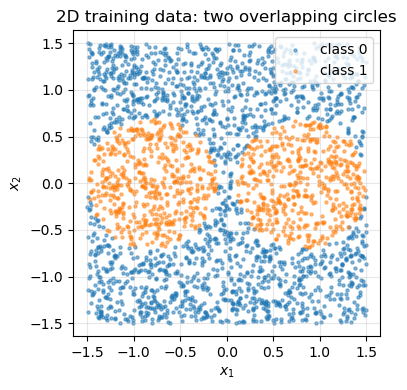

In [3]:
def plot_data(X, y, filename=None, title="Training data"):
    plt.figure(figsize=(4.0, 4.0))
    plt.scatter(X[y==0, 0], X[y==0, 1], s=5, alpha=0.5, label="class 0")
    plt.scatter(X[y==1, 0], X[y==1, 1], s=5, alpha=0.5, label="class 1")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title(title)
    plt.legend(loc="best")
    plt.axis("equal")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

plot_data(X_train, y_train, filename="figs/2d_data_scatter.png",
          title="2D training data: two overlapping circles")


## 2. Helper for Decision-Boundary Plots

We will use a common helper function to visualize decision boundaries of different models:
- the geometric ground truth,
- logistic regression,
- and the neural network.

This will allow direct visual comparison of the learned decision regions.


In [4]:
def plot_decision_boundary(model_func, X, y, filename=None, title="Decision boundary"):
    """Plot decision boundary for a model.

    model_func: function R^2 -> [0,1] giving class-1 probability.
    """
    # Create a grid
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    with torch.no_grad():
        zz = model_func(grid).reshape(xx.shape)

    plt.figure(figsize=(4.0, 4.0))
    # Contourf for probabilities
    cs = plt.contourf(xx, yy, zz, levels=25, alpha=0.7)
    plt.colorbar(cs, label="P(class 1)")

    # Overlay training points
    plt.scatter(X[y==0, 0], X[y==0, 1], s=5, c="k", alpha=0.4, label="class 0")
    plt.scatter(X[y==1, 0], X[y==1, 1], s=5, c="w", edgecolor="k", alpha=0.8, label="class 1")

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title(title)
    plt.axis("equal")
    plt.legend(loc="upper right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


### 3. Ground-Truth Decision Boundary

Before fitting any model, we visualize the _true_ decision boundary implied by the
data-generation process (membership in at least one of the two circles).

This helps us judge whether the models are capturing the correct structure.


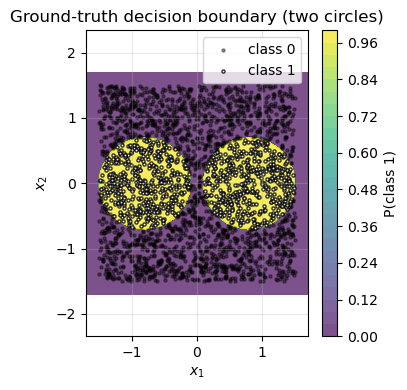

In [5]:
def ground_truth_prob(grid, radius1=0.7, radius2=0.7, offset=0.8):
    c1 = np.array([-offset, 0.0])
    c2 = np.array([+offset, 0.0])
    d1 = np.linalg.norm(grid - c1, axis=1)
    d2 = np.linalg.norm(grid - c2, axis=1)
    inside = ((d1 < radius1) | (d2 < radius2)).astype(np.float32)
    return inside  # probability 0 or 1 for this synthetic setup

plot_decision_boundary(
    model_func=lambda grid: torch.tensor(ground_truth_prob(grid)),
    X=X_train,
    y=y_train,
    filename="figs/ground_truth_boundary.png",
    title="Ground-truth decision boundary (two circles)"
)


## 4. Logistic Regression with Nonlinear Features

We now fit a logistic regression model, but instead of working directly with the raw
2D coordinates, we apply a polynomial feature expansion. This is a classical example of
**explicit feature engineering**: the model remains linear in the transformed feature space,
but the decision boundary in the original (x1, x2) plane becomes nonlinear.


In [6]:
# Polynomial feature expansion
poly = PolynomialFeatures(degree=4, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train_poly, y_train)

y_train_pred = logreg.predict(X_train_poly)
y_test_pred = logreg.predict(X_test_poly)

acc_train_lr = accuracy_score(y_train, y_train_pred)
acc_test_lr = accuracy_score(y_test, y_test_pred)

print(f"Logistic Regression with degree-4 polynomial features:")
print(f"  Train accuracy: {acc_train_lr:.3f}")
print(f"  Test  accuracy: {acc_test_lr:.3f}")


Logistic Regression with degree-4 polynomial features:
  Train accuracy: 0.965
  Test  accuracy: 0.963


### Logistic Regression Decision Boundary

We visualize the decision boundary learned by logistic regression in the original
2D input space.


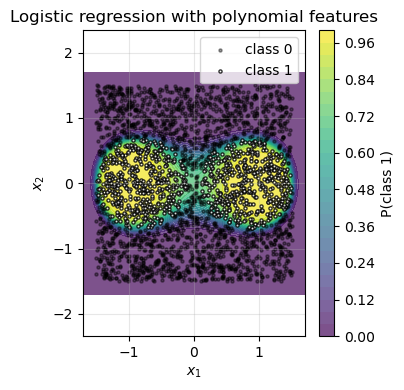

In [7]:
def logreg_model_func(grid):
    grid_poly = poly.transform(grid)
    proba = logreg.predict_proba(grid_poly)[:, 1]
    return torch.tensor(proba.reshape(-1, 1), dtype=torch.float32).squeeze()

plot_decision_boundary(
    model_func=logreg_model_func,
    X=X_train,
    y=y_train,
    filename="figs/logreg_boundary.png",
    title="Logistic regression with polynomial features"
)


## 5. Neural Network with a Single Fully Connected Hidden Layer

We now construct a simple feed-forward neural network:
- 2D input layer,
- one hidden layer with 10 neurons and `tanh` activation,
- a single output neuron with a sigmoid activation (binary classification).

Unlike logistic regression with polynomial features, this network **learns** its own
nonlinear features through the hidden layer.


In [8]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

    def prob(self, x):
        logits = self.forward(x)
        return torch.sigmoid(logits)

# Prepare PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

model = SimpleNN(input_dim=2, hidden_dim=10)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

n_epochs = 5000
loss_history = []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train_t)
    loss = criterion(logits, y_train_t)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch + 1) % 500 == 0:
        with torch.no_grad():
            probs_train = torch.sigmoid(model(X_train_t))
            preds_train = (probs_train > 0.5).float()
            acc_train_nn = (preds_train.eq(y_train_t).float().mean().item())

            probs_test = torch.sigmoid(model(X_test_t))
            preds_test = (probs_test > 0.5).float()
            acc_test_nn = (preds_test.eq(y_test_t).float().mean().item())

        print(f"Epoch {epoch+1:5d} | "
              f"Loss: {loss.item():.4f} | "
              f"Train acc: {acc_train_nn:.3f} | "
              f"Test acc: {acc_test_nn:.3f}")


Epoch   500 | Loss: 0.1329 | Train acc: 0.956 | Test acc: 0.942
Epoch  1000 | Loss: 0.1034 | Train acc: 0.957 | Test acc: 0.947
Epoch  1500 | Loss: 0.0923 | Train acc: 0.962 | Test acc: 0.952
Epoch  2000 | Loss: 0.0599 | Train acc: 0.980 | Test acc: 0.978
Epoch  2500 | Loss: 0.0385 | Train acc: 0.993 | Test acc: 0.990
Epoch  3000 | Loss: 0.0329 | Train acc: 0.993 | Test acc: 0.990
Epoch  3500 | Loss: 0.0294 | Train acc: 0.993 | Test acc: 0.989
Epoch  4000 | Loss: 0.0267 | Train acc: 0.994 | Test acc: 0.991
Epoch  4500 | Loss: 0.0244 | Train acc: 0.994 | Test acc: 0.991
Epoch  5000 | Loss: 0.0223 | Train acc: 0.996 | Test acc: 0.989


### Training Loss History

We plot the training loss as a function of epochs. This helps visualize convergence
behavior and can reveal issues such as underfitting or overfitting.


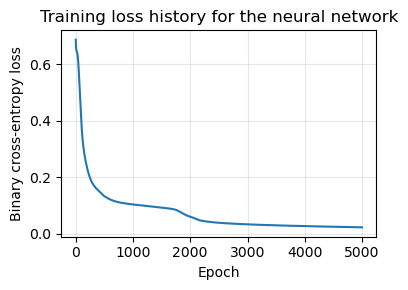

In [9]:
plt.figure(figsize=(4.0, 3.0))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy loss")
plt.title("Training loss history for the neural network")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/nn_loss_history.png", dpi=300, bbox_inches="tight")
plt.show()


### Neural Network Decision Boundary

We now visualize the decision boundary learned by the neural network and compare it
qualitatively with the ground truth and the logistic-regression boundary.


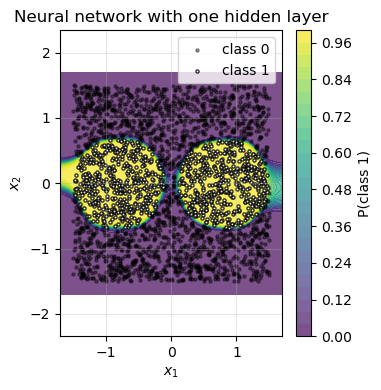

In [10]:
def nn_model_func(grid):
    grid_t = torch.tensor(grid, dtype=torch.float32)
    with torch.no_grad():
        proba = model.prob(grid_t).numpy().reshape(-1)
    return torch.tensor(proba, dtype=torch.float32)

plot_decision_boundary(
    model_func=nn_model_func,
    X=X_train,
    y=y_train,
    filename="figs/nn_boundary.png",
    title="Neural network with one hidden layer"
)


## 6. Comparison and Discussion

From the figures:
- The **ground-truth boundary** (two circles) shows the target geometry.
- **Logistic regression with polynomial features** can approximate this boundary if we choose a sufficiently rich feature set (here, degree 4).
- The **neural network** learns a flexible decision boundary directly from the data, without explicit manual feature design.

This illustrates the conceptual points discussed in Chapter 4:
- Both approaches introduce nonlinearity but in different ways.
- Neural networks shift the burden from manual feature engineering to learned internal representations.
